# Data Loading

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

In [2]:
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 
            'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 
            'P1', 'Pz', 'P2', 'POz']

In [3]:
raw = mne.io.read_raw_gdf('./data/A01T.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])


Extracting EDF parameters from /home/seohyunseo/eeg_signal_processing_v2/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/seohyunseo/.conda/envs/h_shs/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MB, data loaded>

In [4]:
for i in range(len(ch_names)):
    raw.rename_channels({
        raw.info["ch_names"][i]: ch_names[i]
    })

In [5]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MB, data loaded>

In [6]:
# Check for NaN or inf values in your data
has_nan = np.isnan(raw.get_data()).any()
has_inf = np.isinf(raw.get_data()).any()

print(f'NaN: {has_nan}, Inf: {has_inf}')

NaN: False, Inf: False


# Raw Data visualization

In [7]:
# fig = raw.plot(scalings='auto', show=True)

In [8]:
# Plot the power spectral density 
# fig = raw.compute_psd(fmax=60, picks=[0]).plot(picks="data", exclude="bads", amplitude=False)

# Preprocessing

### Rereferencing

In [9]:
ref_ch = ['Cz'] # Change reference channel as you want
# Use the average of all channels as reference
ref_avr = "average"

# Conduct CAR (Common Average Reference)
raw_ref = raw.copy().set_eeg_reference(ref_channels=ref_avr)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Epoching

In [10]:
events = mne.events_from_annotations(raw_ref)
events[0].shape

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(603, 3)

In [11]:
event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,
}

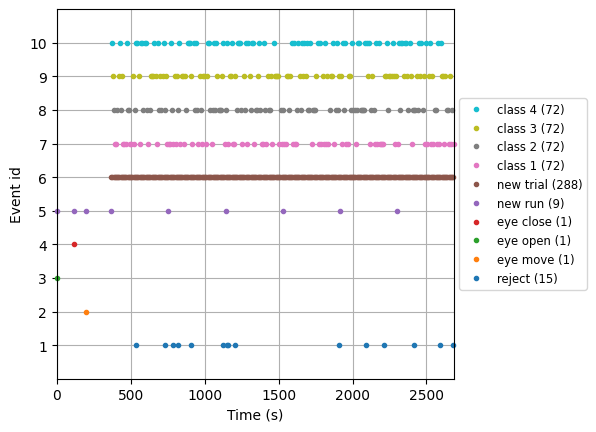

In [12]:
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw_ref.first_samp)

In [13]:
# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes 
tmin = -.5
tmax = 3.5
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True, baseline=None)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped


In [14]:
'''
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True)
if baseline parameter isn't passed like above, then it is applied automatically 
'''
# Baseline correction
# baseline = (None, 0)
# epochs.apply_baseline(baseline)

"\nepochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True)\nif baseline parameter isn't passed like above, then it is applied automatically \n"

Using matplotlib as 2D backend.


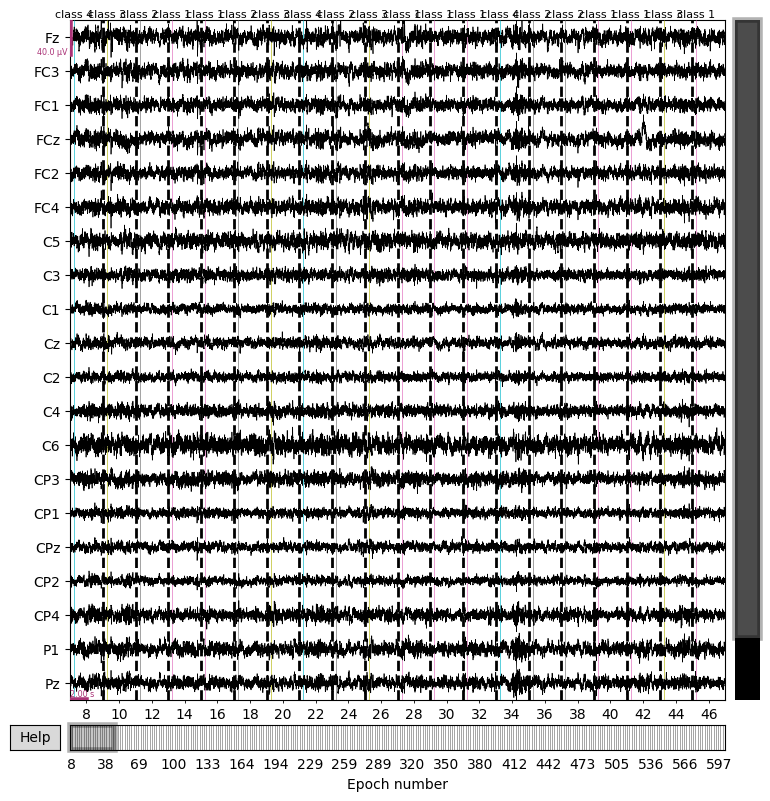

In [15]:
# Plot epoched data
fig = epochs.plot(events=events[0],
                  event_id=event_dict)

In [16]:
# Check for NaN or inf values in your data
has_nan = np.isnan(epochs.get_data(copy=False)).any()
has_inf = np.isinf(epochs.get_data(copy=False)).any()

print(f'NaN: {has_nan}, Inf: {has_inf}')

NaN: False, Inf: False


### Band-pass Filtering
0.05 - 50.0 Hz

In [17]:
# Filter the raw signal with a band pass filter in 0.5 - 50.0 Hz
l_freq = .05
h_freq = 70.0
iir_params = dict(order=8, ftype="butter")
epochs.filter(l_freq, h_freq, picks='eeg', method='iir', iir_params=iir_params)

Setting up band-pass filter from 0.05 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 0.05, 70.00 Hz: -6.02, -6.02 dB



<Epochs |  288 events (all good), -0.5 – 3.5 s, baseline off, ~48.4 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>

In [18]:
# Plot power spectral density filtered data
# epochs.compute_psd(fmax=70).plot()

### Removing artifact with ICA

In [19]:
# Create ICA object first
ica_obj = mne.preprocessing.ICA(
                    n_components=0.99,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True))

In [20]:
ica_obj.fit(epochs)

Fitting ICA to data using 22 channels (please be patient, this may take a while)


Selecting by explained variance: 14 components
Computing Extended Infomax ICA
Fitting ICA took 31.9s.


<ICA | epochs decomposition, method: infomax (fit in 500 iterations on 288288 samples), 14 ICA components (22 PCA components available), channel types: eeg, no sources marked for exclusion>

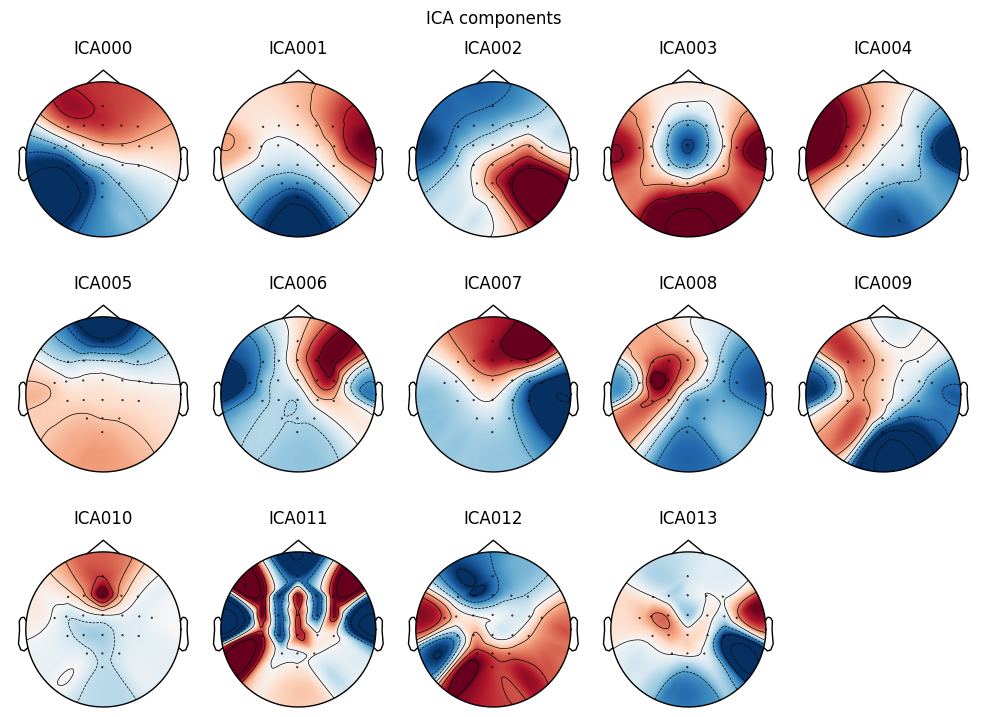

In [21]:
# Plot the ICA components
fig = ica_obj.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


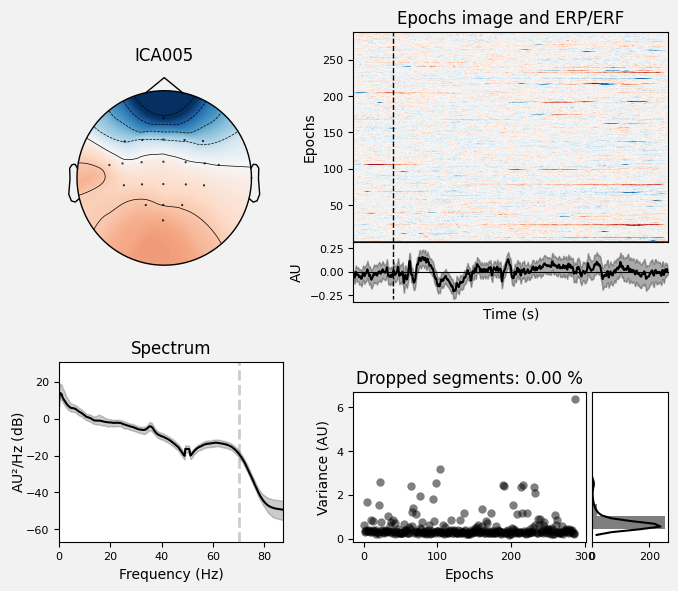

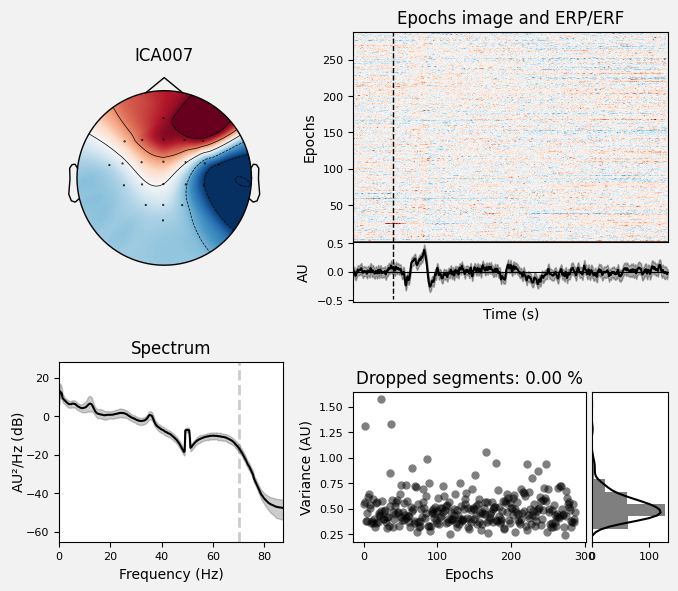

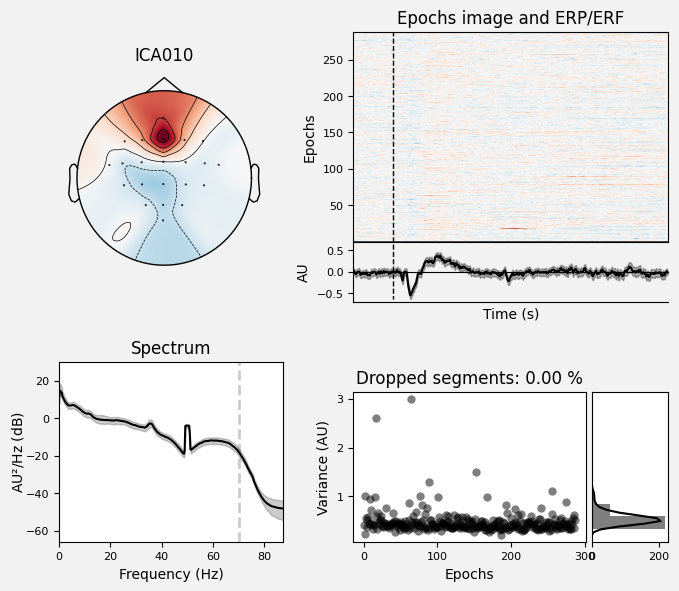

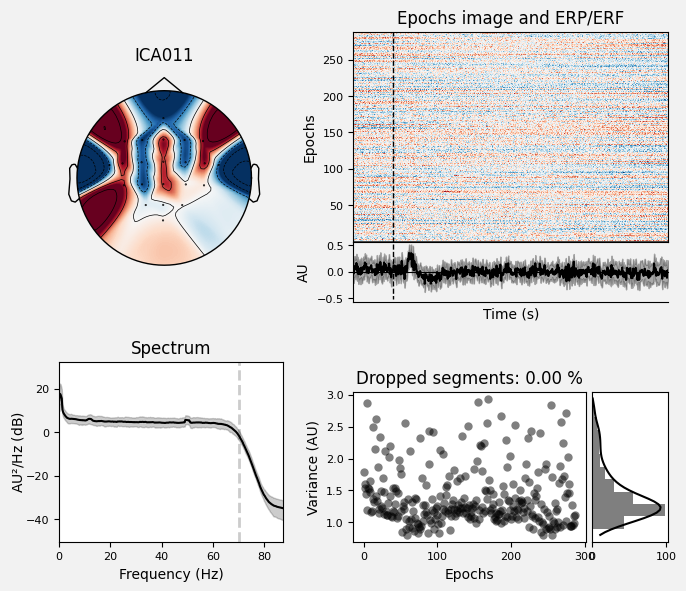

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [22]:
# plot diagnostics
ica_obj.plot_properties(epochs, picks=[5, 7, 10, 11])

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


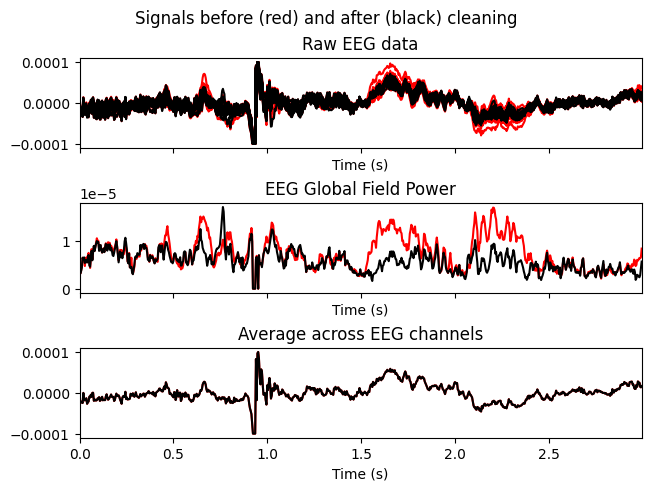

In [23]:
# blinks
fig = ica_obj.plot_overlay(raw, exclude=[5], picks="eeg")

In [24]:
# Drop bad ICA components
ica_obj.exclude = [5]
ica_obj.apply(epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


<Epochs |  288 events (all good), -0.5 – 3.5 s, baseline off, ~48.4 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>

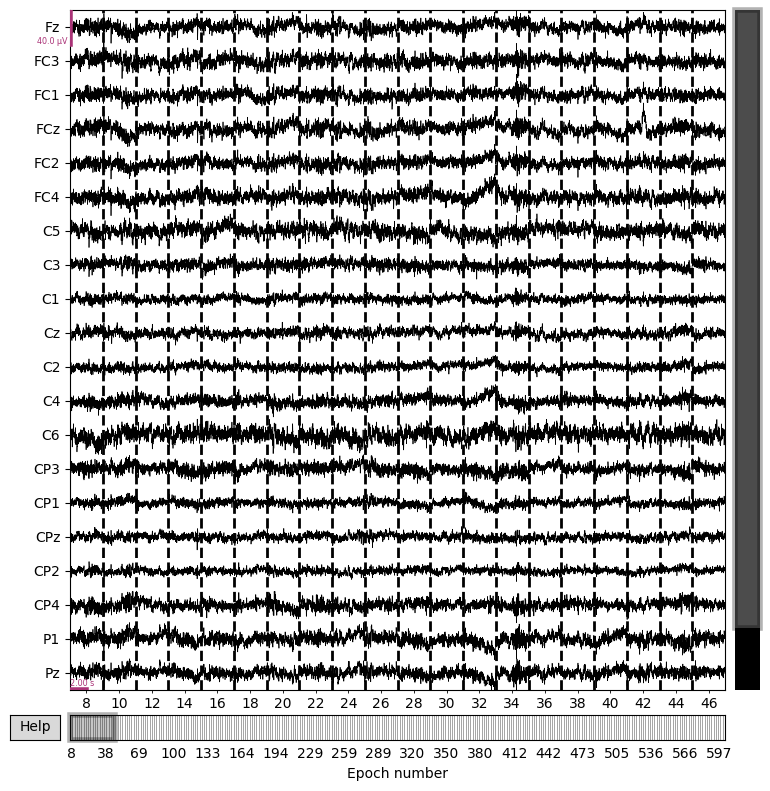

In [25]:
fig = epochs.plot()

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


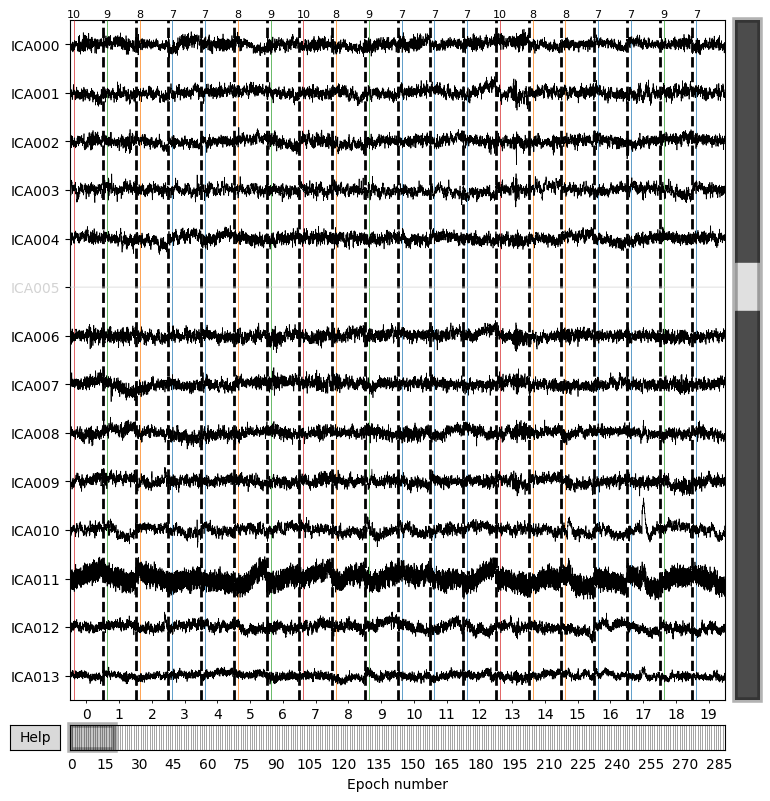

In [26]:
# Plot the ICA scources
fig = ica_obj.plot_sources(epochs)

In [27]:
# Drop bad epochs by observing
epochs.drop([45, 56])

Dropped 2 epochs: 45, 56


<Epochs |  286 events (all good), -0.5 – 3.5 s, baseline off, ~48.1 MB, data loaded,
 '7': 72
 '8': 70
 '9': 72
 '10': 72>

# Feature Analysis

In [28]:
# Get label from processed epochs
labels = epochs.events[:, -1]
labels.shape

(286,)

In [29]:
evoked_1 = epochs['7'].average()
evoked_2 = epochs['8'].average()
evoked_3 = epochs['9'].average()
evoked_4 = epochs['10'].average()
evoked_arr = [evoked_1, evoked_2, evoked_3, evoked_4]

In [30]:
evk_1 = evoked_1.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_2 = evoked_2.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_3 = evoked_3.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_4 = evoked_4.copy().pick(picks=['C3', 'C4', 'Cz'])


In [31]:
data = [evk_1.get_data(), evk_2.get_data(),evk_3.get_data(),evk_4.get_data() ]
ch = ['C3', 'C4', 'Cz']
cls = ['Left', 'Right', 'Feet', 'Tongue']

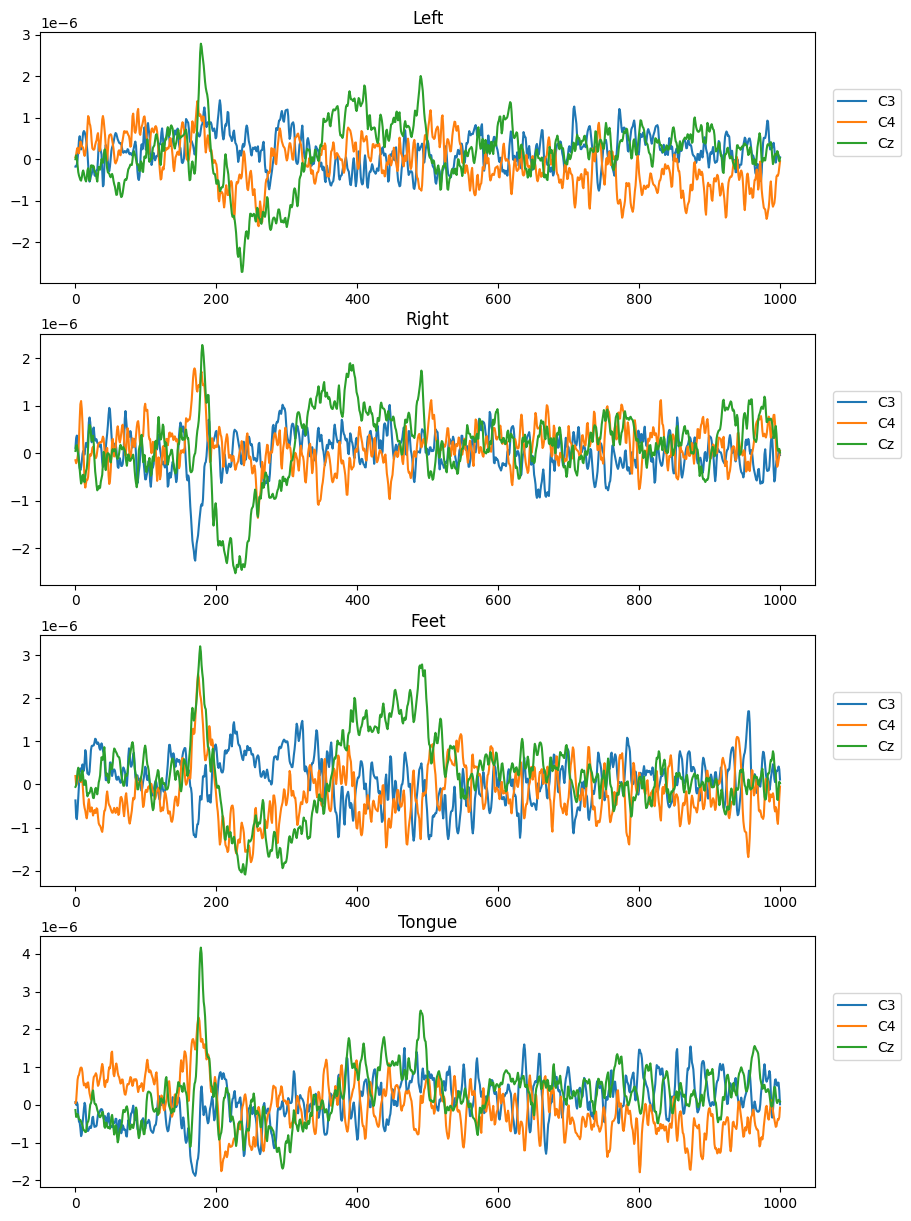

In [32]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

for i in range(len(data)):
    for j in range(len(ch)):
        axes[i].plot(data[i][j], label=ch[j])
    axes[i].set_title(cls[i])
    axes[i].legend(bbox_to_anchor=(1.12, .8))

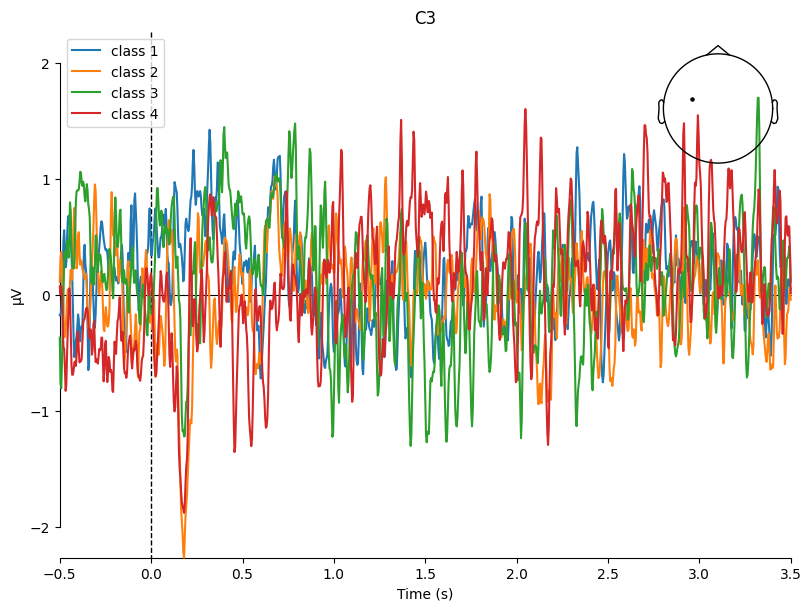

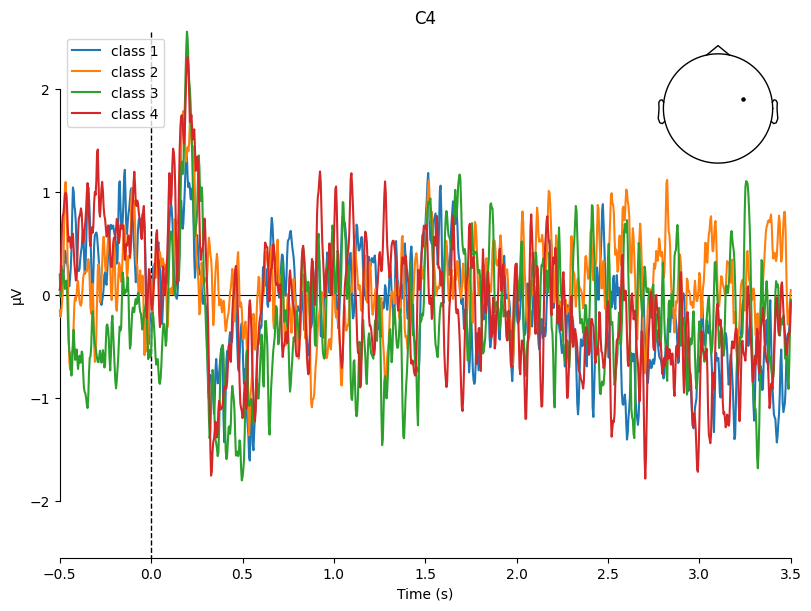

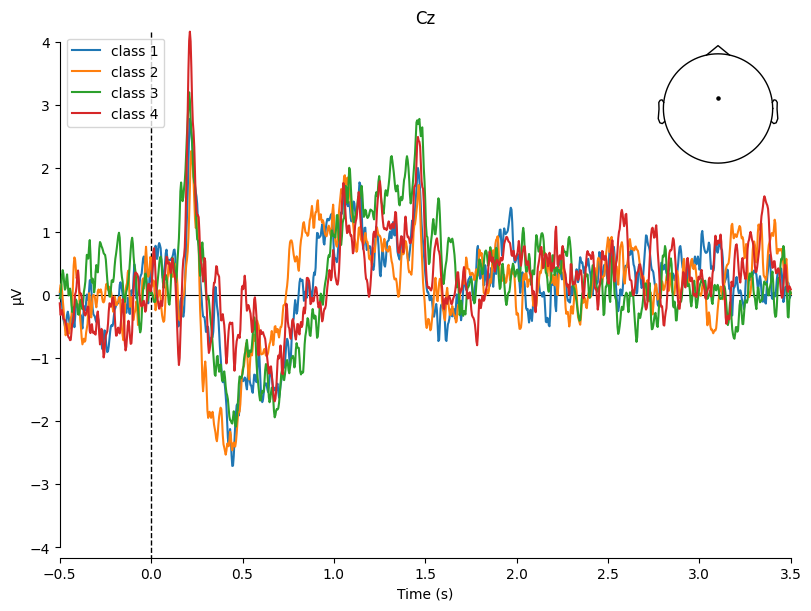

In [33]:
#left,right,foot,tongue
dicts={'class 1':evoked_1,'class 2':evoked_2,'class 3':evoked_3,'class 4':evoked_4}
for i in range(len(ch)):
    mne.viz.plot_compare_evokeds(dicts, picks=ch[i])

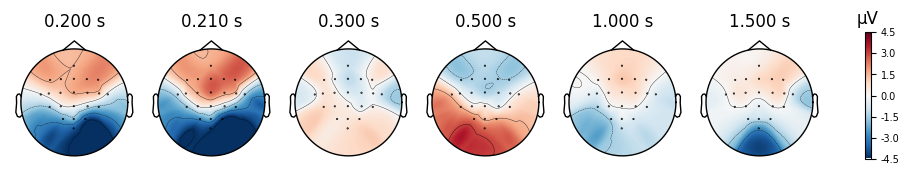

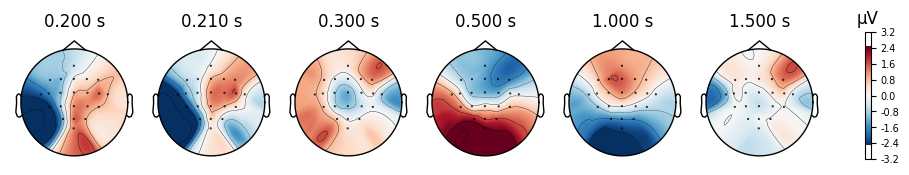

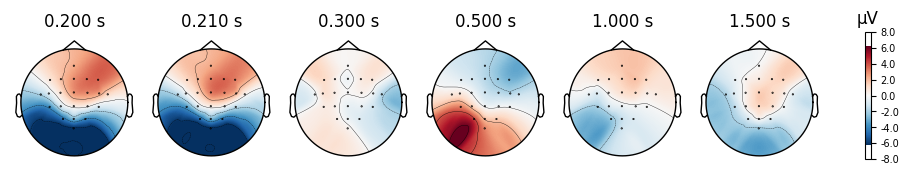

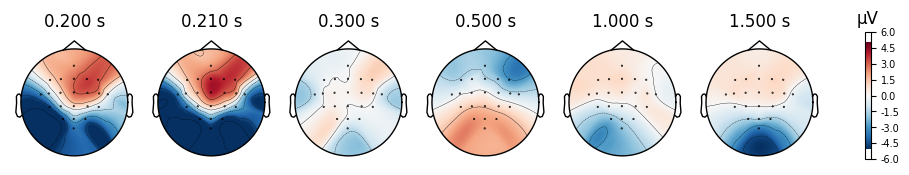

In [34]:
for evoked in evoked_arr:
    fig = evoked.plot_topomap(times=[.2,.21, .3, .5, 1., 1.5,])
    

In [35]:
# for evoked in evoked_arr:
#     fig = evoked.compute_psd().plot_topomap()

In [36]:
# # Define frequency parameters
# freqs = np.arrange(2, 36)  # Define the frequencies of interest (in Hz)
# n_cycles = 5  # Number of cycles for the Morlet wavelet

In [37]:
# for i in range(len(evoked_arr)):
#     for c in ch:
#         # Compute time-frequency representation (TFR)
#         tfr = mne.time_frequency.tfr_morlet(evoked_arr[i].copy().pick(picks=ch), freqs=freqs, n_cycles=freqs, return_itc=False)
#         # Plot power spectral density (PSD)
#         tfr.plot([0], baseline=(None, 0), title=f'{cls[i]} with {c}')

In [38]:
from mne.decoding import CSP
from sklearn.preprocessing import normalize

In [39]:
epochs_data = epochs.get_data(copy=False)
# L2 normalization along the channel axis
reshaped_data = epochs_data.reshape(-1, epochs_data.shape[-1])
normalized_data = normalize(reshaped_data, axis=1, norm='l2')
# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(epochs_data.shape)

In [40]:
# Assemble a classifier
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.6e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.13 (2.2e-16 eps * 22 dim * 2.6e+13  max singular value)
    Estimate

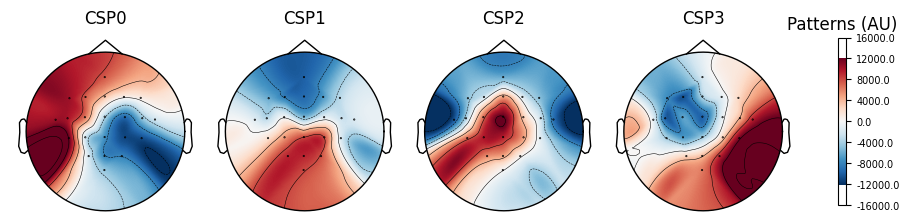

In [41]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(normalized_data, labels)

fig = csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

# Feature Extraction

In [42]:
from scipy import signal
import scipy.stats as stats

In [43]:
# Extract C3, C4, Cz
epochs_c = epochs.copy().pick(picks=['C3', 'C4', 'Cz'])

### Statistical Analysis

In [44]:
# A function to extract statistical features from each epoch
def statistical_features(epoch):
    features = []
    
    # Example: Mean, Standard Deviation, Skewness, and Kurtosis
    features.append(np.mean(epoch, axis=1))
    features.append(np.std(epoch, axis=1))
    features.append(stats.skew(epoch, axis=1))
    features.append(stats.kurtosis(epoch, axis=1))
    
    # Add more statistical features as needed
    return np.concatenate(features)

In [45]:
# Extract features for each epoch
statistical_feature_matrix = np.array([statistical_features(epoch) for epoch in epochs.get_data(copy=False)])

In [46]:
statistical_feature_matrix.shape

(286, 88)

### Wavelet Trasform


In [47]:
# Define the wavelet transform function
def wavelet_transform(epoch, scales):
    wavelet_features = []
    channels = epoch.shape[0]
    for channel in range(channels):
        for scale in scales:
            # Apply continuous wavelet transform (CWT)
            wavelet_data = signal.cwt(epoch[channel, :], signal.morlet, [scale])

            # Extract features (e.g., mean, variance) from the wavelet coefficients
            wavelet_features.append(np.mean(np.abs(wavelet_data)))
            wavelet_features.append(np.var(np.abs(wavelet_data)))

    return np.array(wavelet_features)

In [48]:
scales = np.arange(1, 2)  # Adjust the range of scales based on your requirements

# Extract wavelet transform features for each epoch
wavelet_feature_matrix = np.array([wavelet_transform(epoch, scales) for epoch in epochs.get_data(copy=False)])


In [49]:
wavelet_feature_matrix.shape

(286, 44)

### Blind Source Separation

In [50]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD

### Blind Source Separation: CSP

In [51]:
# Assemble a classifier
csp = CSP(n_components=20, reg=None, log=True, norm_trace=False)

In [52]:
csp_feature_matrix = csp.fit_transform(normalized_data, labels)
csp_feature_matrix.shape

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.6e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.13 (2.2e-16 eps * 22 dim * 2.6e+13  max singular value)
    Estimate

(286, 20)

### Blind Source Separation: ICA

In [53]:
# Reshape the data to (n_samples, n_features)
epochs_reshaped = epochs.get_data(copy=False).reshape(epochs.get_data(copy=False).shape[0], -1)
epochs_reshaped.shape

(286, 22022)

In [54]:
ica = FastICA(n_components=4, random_state=42)

ica_feature_matrix = ica.fit_transform(epochs_reshaped)

ica_feature_matrix.shape

/home/seohyunseo/.conda/envs/h_shs/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(286, 4)

### Blind Source Separation: PCA

In [55]:
# Initialize PCA model
pca = PCA(n_components=30)

# Transform the data using the learned PCA components
pca_feature_matrix = pca.fit_transform(epochs_reshaped)

pca_feature_matrix.shape

(286, 30)

### Blind Source Separation: SVD

In [56]:
svd = TruncatedSVD(n_components=43, random_state=42)
svd_feature_matrix = svd.fit_transform(epochs_reshaped)
svd_feature_matrix.shape

(286, 43)

### PSD (Power Spectral Density) 

In [57]:
# Function to compute PSD features for a single trial
def compute_psd_features(epoch, freq_bands, sfreq=1000):
    psd_features = []
    for channel_data in epoch:
        _, psd = signal.welch(channel_data, fs=sfreq, nperseg=len(channel_data))
        for f_band in freq_bands:
            band_psd = np.sum(psd[(f_band[0] <= _) & (_ <= f_band[1])])
            psd_features.append(band_psd)
    return psd_features

In [58]:
# Define the frequency bands of interest
freq_bands = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 40)] # Delta(0.5-4 Hz), Theta(4-8 Hz), Alpha(8-13 Hz), Beta(14-30 Hz), Gamma(30Hz -)

In [59]:
# Sampling Rate of epochs
s_freq = epochs.info['sfreq']
# Apply the PSD feature extraction to all trials
psd_feature_matrix = [compute_psd_features(epoch, freq_bands, sfreq=s_freq) for epoch in epochs.get_data(copy=False)]

# Convert the list to a NumPy array
psd_feature_matrix = np.array(psd_feature_matrix)
psd_feature_matrix.shape

(286, 110)

### Filter Back Common Spatial Pattern (FBCSP)
1. Frequecy Filtering

2. Spatial Filtering

3. Feature Selection

4. Classification

Reference: https://ieeexplore.ieee.org/document/4634130

In [60]:
from mne.filter import filter_data
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif

Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:


- Filter order 32 (effective, after forward-backward)
- Cutoffs at 8.00, 12.00 Hz: -6.02, -6.02 dB



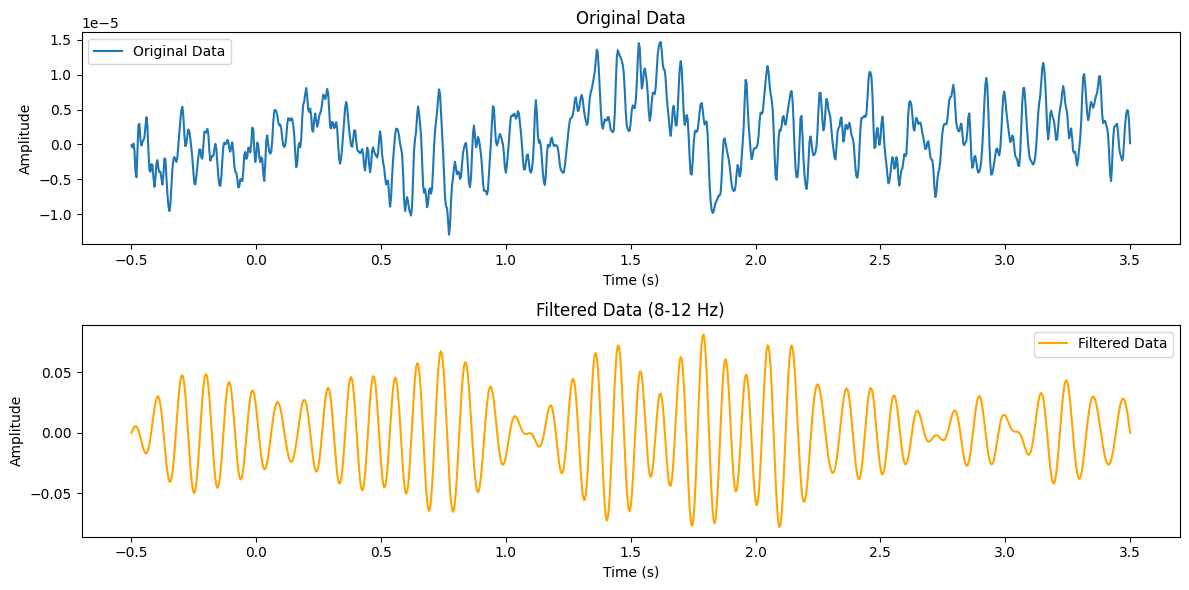

In [61]:
# Check if the normalization and band pass filter work well

ir_params = dict(order=20, ftype="butter")
# Apply bandpass filter to the data
low_freq, high_freq = 8, 12  # Replace with your desired frequency range
filtered_data = filter_data(epochs.get_data(copy=False), epochs.info['sfreq'], low_freq, high_freq, method='iir', iir_params=iir_params)

reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])

# L2 normalization along the channel axis
normalized_data = normalize(reshaped_data, axis=1, norm='l2')

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(filtered_data.shape)

# Plot the original and filtered data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs.times, epochs.get_data(copy=False)[0][1], label='Original Data')
plt.title(f'Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs.times, normalized_data[0][1], label='Filtered Data', color='orange')
plt.title(f'Filtered Data ({low_freq}-{high_freq} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Step 1: Frequency Filtering

# Filter Bank CSP
freq_bands = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 40)]  # Define frequency bands
# freq_bands = list(zip(range(1, 30), range(2, 31)))

csp_filters = []

In [63]:
# Step 2: Spatial Filtering & Step 3: Feature Selection

# Number of top features to select (k)
k = 10  # Adjust as needed

# Initialize an empty array to store average mutual information values
average_mi_values = np.zeros(len(freq_bands))

# Initialize an empty array to store k best selected features
fbcsp_feature_matrix = []

# Initialize a parameters to band bass filter
ir_params = dict(order=4, ftype="butter")

In [64]:
# # Loop through each frequency band
# for idx, (low, high) in enumerate(freq_bands):

#     # Apply bandpass filter to the data
#     filtered_data = filter_data(epochs.get_data(copy=False), sfreq=epochs.info['sfreq'], l_freq=low, h_freq=high, verbose=False, method='iir', iir_params=iir_params)

#     # L2 normalization along the channel axis
#     reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])
#     normalized_data = normalize(reshaped_data, axis=1, norm='l2')
#     # Reshape the normalized data back to the original shape
#     normalized_data = normalized_data.reshape(filtered_data.shape)

#     # Apply CSP
#     csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
#     csp.fit(normalized_data, labels)
#     csp_filters = np.array(csp.filters_)

#     # Apply CSP filters to original EEG data
#     features = np.dot(csp_filters, normalized_data)
#     features_reshaped = features.reshape(features.shape[1], -1)
#     fbcsp_feature_matrix.append(features_reshaped) 

#     # Compute mutual information for each individual feature
#     mi_values = mutual_info_classif(features_reshaped, labels)

#     # Calculate average mutual information for the current frequency band
#     average_mi_values[idx] = np.mean(mi_values)

In [65]:
# Loop through each frequency band
for idx, (low, high) in enumerate(freq_bands):

    # Apply bandpass filter to the data
    filtered_data = filter_data(epochs.get_data(copy=False), sfreq=epochs.info['sfreq'], l_freq=low, h_freq=high, verbose=False, method='iir', iir_params=iir_params)

    # L2 normalization along the channel axis
    reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])
    normalized_data = normalize(reshaped_data, axis=1, norm='l2')
    # Reshape the normalized data back to the original shape
    normalized_data = normalized_data.reshape(filtered_data.shape)

    # Apply CSP
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    csp_feature = csp.fit_transform(normalized_data, labels)

    # Apply CSP filters to original EEG data
    # features = np.dot(csp_filters, normalized_data)
    # features_reshaped = features.reshape(features.shape[1], -1)
    fbcsp_feature_matrix.append(csp_feature) 

    # Compute mutual information for each individual feature
    mi_values = mutual_info_classif(csp_feature, labels)

    # Calculate average mutual information for the current frequency band
    average_mi_values[idx] = np.mean(mi_values)

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.13 (2.2e-16 eps * 22 dim * 2.6e+13  max singular value)
    Estimate

In [66]:
np.array(fbcsp_feature_matrix).shape

(5, 286, 4)

In [67]:
# Select the top k frequency bands with the highest average mutual information
selected_freq_band_indices = np.argsort(-average_mi_values)[:k]
selected_freq_bands = [freq_bands[i] for i in selected_freq_band_indices]
fbcsp_feature_matrix = np.array([fbcsp_feature_matrix[i] for i in selected_freq_band_indices])

print(f"Selected Frequency Bands: {selected_freq_bands}")
print(f"Selected Feature Matrix: {fbcsp_feature_matrix.shape}")

Selected Frequency Bands: [(8, 13), (13, 30), (30, 40), (0.5, 4), (4, 8)]
Selected Feature Matrix: (5, 286, 4)


In [68]:
fbcsp_feature_matrix = fbcsp_feature_matrix.reshape(fbcsp_feature_matrix.shape[1], -1)
fbcsp_feature_matrix.shape

(286, 20)

# Feature Selection

In [69]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [70]:
# Combine all feature sets horizontally
all_features = np.hstack((statistical_feature_matrix, wavelet_feature_matrix, 
                          csp_feature_matrix, pca_feature_matrix, 
                          ica_feature_matrix, psd_feature_matrix,
                          fbcsp_feature_matrix))
all_features.shape

(286, 316)

In [71]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)

In [72]:
# Change the number of selected features as needed
k = 300

In [73]:
# Create a pipeline
feature_selection_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('feature_selection', SelectKBest(score_func=f_classif, k=k)),  # Adjust 'k' as needed
    ('svm', SVC()),  # SVM classifier
])

In [74]:
# Train the pipeline on the training data
feature_selection_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=300)), ('svm', SVC())])

In [75]:
# Extract selected features using SelectKBest
selected_features_mask = feature_selection_pipeline.named_steps['feature_selection'].get_support()

In [76]:
# Apply the mask to the original feature matrix
features_selected = all_features[:, selected_features_mask]

In [77]:
features_selected.shape

(286, 300)

In [78]:
# Make predictions on the test data
y_pred = feature_selection_pipeline.predict(X_test)
# Evaluate the performance of the pipeline
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.64


# Evaluation

In [79]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [80]:
def evaluate_tsne(X, y, name=None):
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Plot the 2D t-SNE representation
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
    plt.title(f't-SNE Visualization for {name}')
    plt.legend(*scatter.legend_elements(), title='Classes')
    plt.show()

In [81]:
def evaluate_svm(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features (optional but recommended)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create an SVM classifier
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

    # Train the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)
    
    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Classification Report:\n', classification_rep)

### Run with Original data

In [82]:
features_origin = epochs_data.reshape(epochs_data.shape[0], -1)
features_origin.shape

(286, 22022)

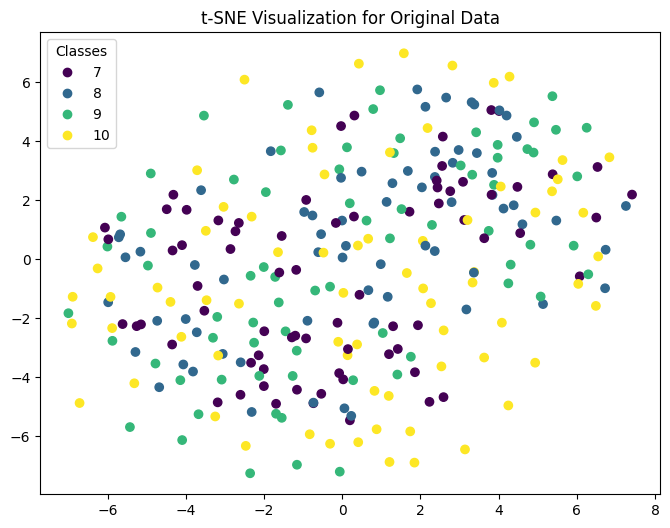

In [83]:
evaluate_tsne(features_origin, labels, 'Original Data')

In [84]:
evaluate_svm(features_origin, labels)

Accuracy: 0.36
Classification Report:
               precision    recall  f1-score   support

           7       0.38      0.48      0.42        23
           8       0.24      0.25      0.24        20
           9       0.38      0.45      0.41        20
          10       0.50      0.26      0.34        23

    accuracy                           0.36        86
   macro avg       0.37      0.36      0.35        86
weighted avg       0.38      0.36      0.36        86



In [85]:
# evaluate_feature(features_origin, labels, 'Original Data')

### Run with Statistical Feature 

In [86]:
features_static = statistical_feature_matrix

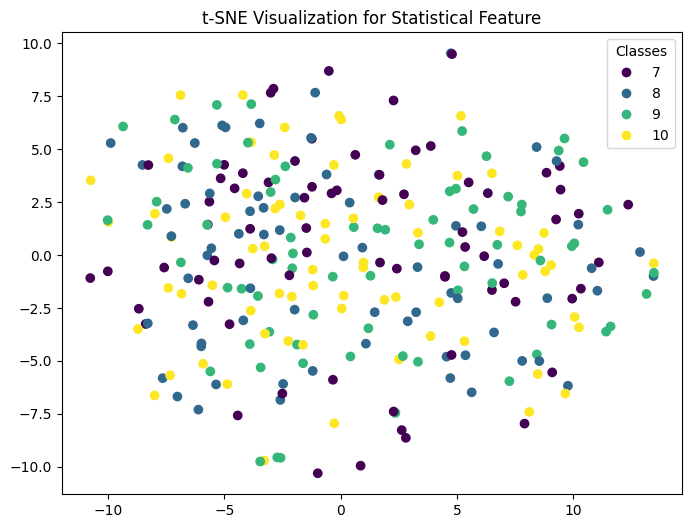

In [87]:
evaluate_tsne(features_static, labels, 'Statistical Feature')

In [88]:
evaluate_svm(features_static, labels)

Accuracy: 0.35
Classification Report:
               precision    recall  f1-score   support

           7       0.41      0.57      0.47        23
           8       0.35      0.30      0.32        20
           9       0.10      0.10      0.10        20
          10       0.53      0.39      0.45        23

    accuracy                           0.35        86
   macro avg       0.35      0.34      0.34        86
weighted avg       0.36      0.35      0.35        86



In [89]:
# evaluate_feature(features_static, labels, 'Statistical Feature')

### Run with Wavelet Trasform Feature

In [90]:
features_wav = wavelet_feature_matrix

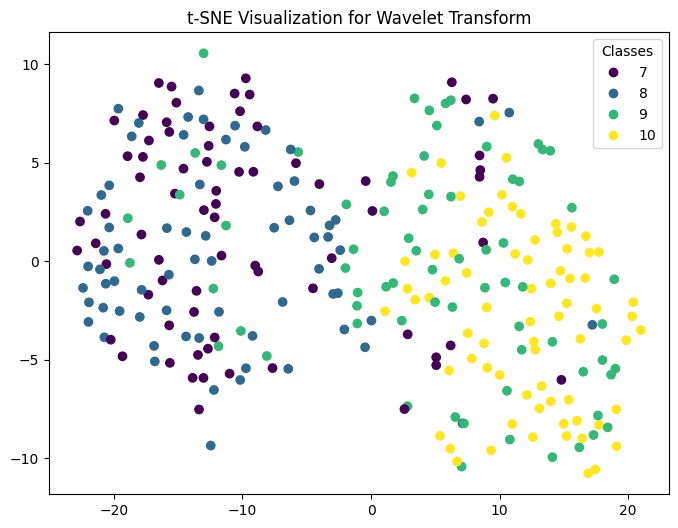

In [91]:
evaluate_tsne(features_wav, labels, 'Wavelet Transform')

In [92]:
evaluate_svm(features_wav, labels)

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           7       0.57      0.74      0.64        23
           8       0.68      0.65      0.67        20
           9       0.44      0.40      0.42        20
          10       0.63      0.52      0.57        23

    accuracy                           0.58        86
   macro avg       0.58      0.58      0.58        86
weighted avg       0.58      0.58      0.58        86



In [93]:
# evaluate_feature(features_wav, labels, 'Wavelet Transform Feature')

### Run with CSP

In [94]:
features_csp = csp_feature_matrix

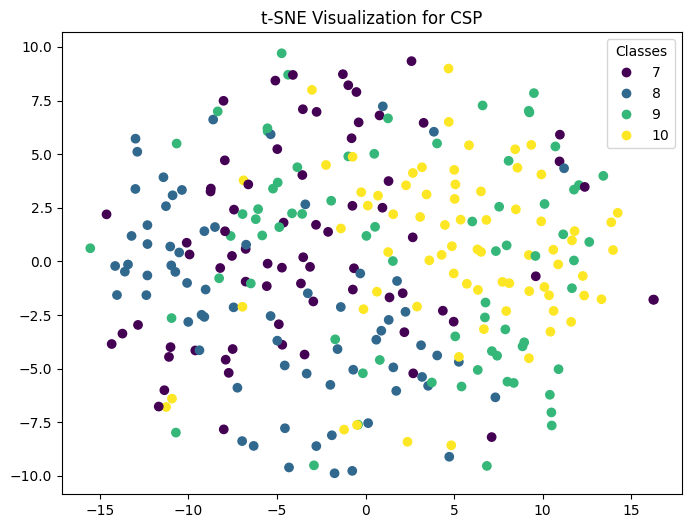

In [95]:
evaluate_tsne(features_csp, labels, 'CSP')

In [96]:
evaluate_svm(features_csp, labels)

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           7       0.52      0.48      0.50        23
           8       0.35      0.55      0.43        20
           9       0.50      0.40      0.44        20
          10       0.72      0.57      0.63        23

    accuracy                           0.50        86
   macro avg       0.53      0.50      0.50        86
weighted avg       0.53      0.50      0.51        86



In [97]:
# evaluate_feature(features_csp, labels, 'CSP Feature')

### Run with ICA

In [98]:
features_ica = ica_feature_matrix

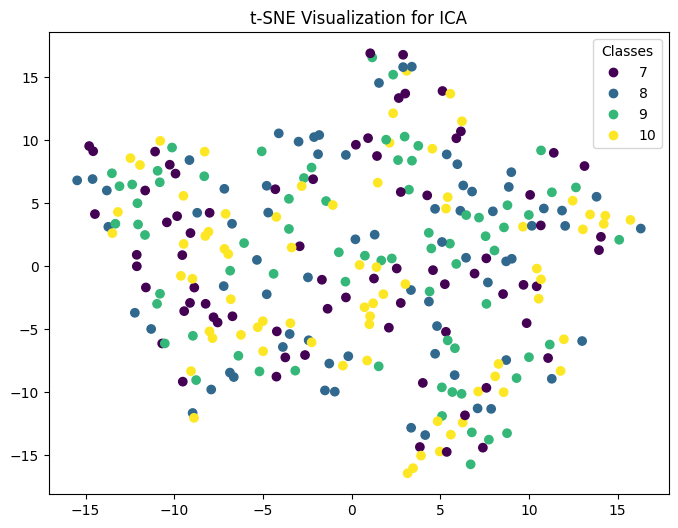

In [99]:
evaluate_tsne(features_ica, labels, 'ICA')

In [100]:
evaluate_svm(features_ica, labels)

Accuracy: 0.09
Classification Report:
               precision    recall  f1-score   support

           7       0.08      0.04      0.06        23
           8       0.11      0.15      0.12        20
           9       0.08      0.15      0.11        20
          10       0.11      0.04      0.06        23

    accuracy                           0.09        86
   macro avg       0.10      0.10      0.09        86
weighted avg       0.10      0.09      0.09        86



In [101]:
# evaluate_feature(features_ica, labels, 'ICA Feature')

### Run with PCA

In [102]:
features_pca = pca_feature_matrix

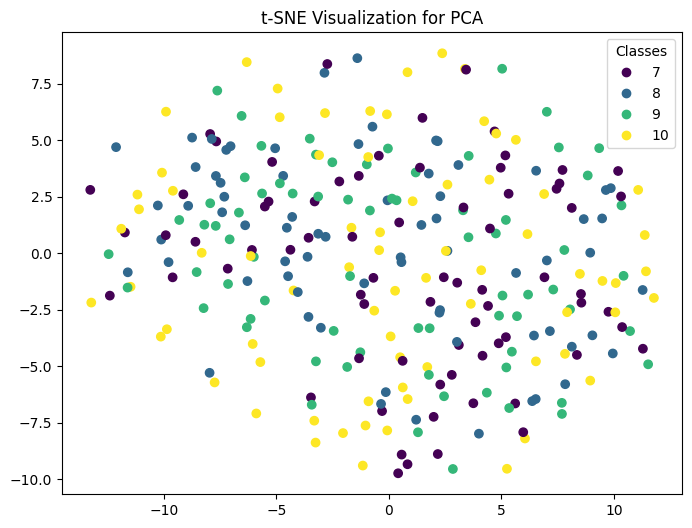

In [103]:
evaluate_tsne(features_pca, labels, 'PCA')

In [104]:
evaluate_svm(features_pca, labels)

Accuracy: 0.33
Classification Report:
               precision    recall  f1-score   support

           7       0.26      0.43      0.32        23
           8       0.24      0.20      0.22        20
           9       0.43      0.45      0.44        20
          10       0.56      0.22      0.31        23

    accuracy                           0.33        86
   macro avg       0.37      0.33      0.32        86
weighted avg       0.37      0.33      0.32        86



In [105]:
# evaluate_feature(features_pca, labels, 'PCA Feature')

### Run with SVD

In [106]:
features_svd = svd_feature_matrix

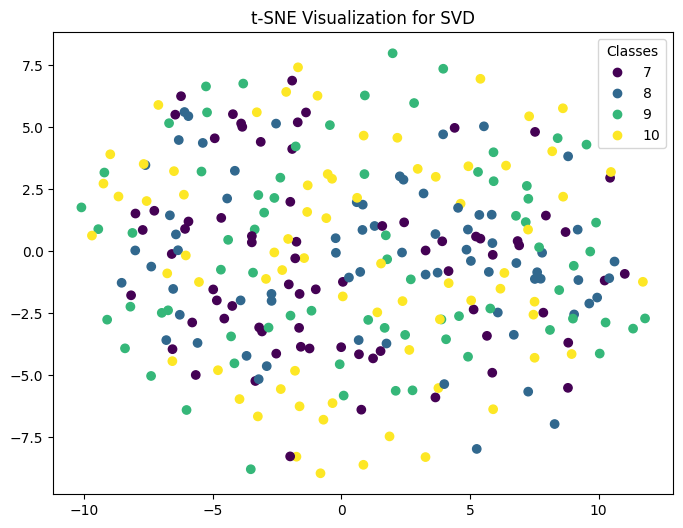

In [107]:
evaluate_tsne(features_svd, labels, 'SVD')

In [108]:
evaluate_svm(features_svd, labels)

Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

           7       0.26      0.43      0.33        23
           8       0.18      0.10      0.13        20
           9       0.43      0.50      0.47        20
          10       0.50      0.30      0.38        23

    accuracy                           0.34        86
   macro avg       0.34      0.33      0.33        86
weighted avg       0.35      0.34      0.33        86



In [109]:
# evaluate_feature(features_svd, labels, 'SVD Feature')

### Run with PSD

In [110]:
features_psd = psd_feature_matrix

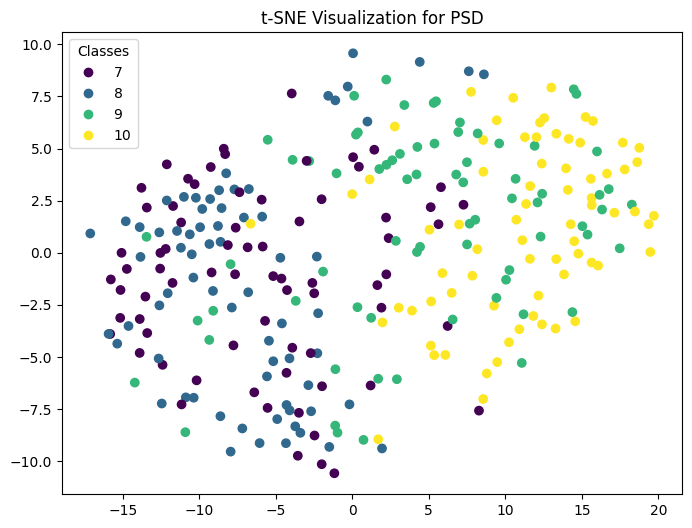

In [111]:
evaluate_tsne(features_psd, labels, 'PSD')

In [112]:
evaluate_svm(features_psd, labels)

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           7       0.74      0.61      0.67        23
           8       0.64      0.70      0.67        20
           9       0.54      0.65      0.59        20
          10       0.71      0.65      0.68        23

    accuracy                           0.65        86
   macro avg       0.66      0.65      0.65        86
weighted avg       0.66      0.65      0.65        86



In [113]:
# evaluate_feature(feature_psd, labels, 'PSD Feature')

### Run with FBCSP

In [114]:
features_fbcsp = fbcsp_feature_matrix

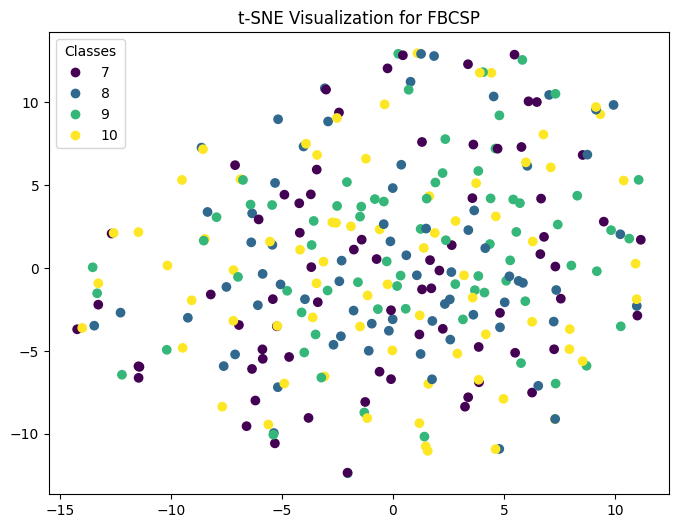

In [115]:
evaluate_tsne(features_fbcsp, labels, 'FBCSP')

In [116]:
evaluate_svm(features_fbcsp, labels)

Accuracy: 0.16
Classification Report:
               precision    recall  f1-score   support

           7       0.14      0.13      0.14        23
           8       0.18      0.20      0.19        20
           9       0.20      0.25      0.22        20
          10       0.11      0.09      0.10        23

    accuracy                           0.16        86
   macro avg       0.16      0.17      0.16        86
weighted avg       0.16      0.16      0.16        86



### Run with All Features

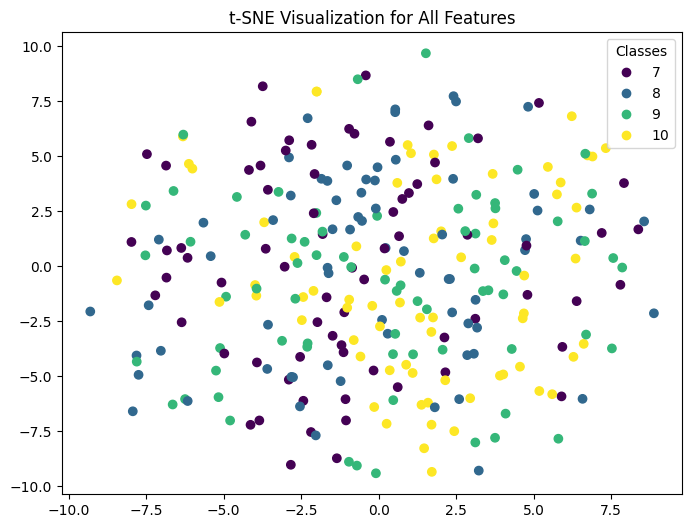

In [117]:
evaluate_tsne(all_features, labels, 'All Features')

In [118]:
evaluate_svm(all_features, labels)

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           7       0.52      0.61      0.56        23
           8       0.59      0.50      0.54        20
           9       0.50      0.55      0.52        20
          10       0.80      0.70      0.74        23

    accuracy                           0.59        86
   macro avg       0.60      0.59      0.59        86
weighted avg       0.61      0.59      0.60        86



### Run with Selected Features

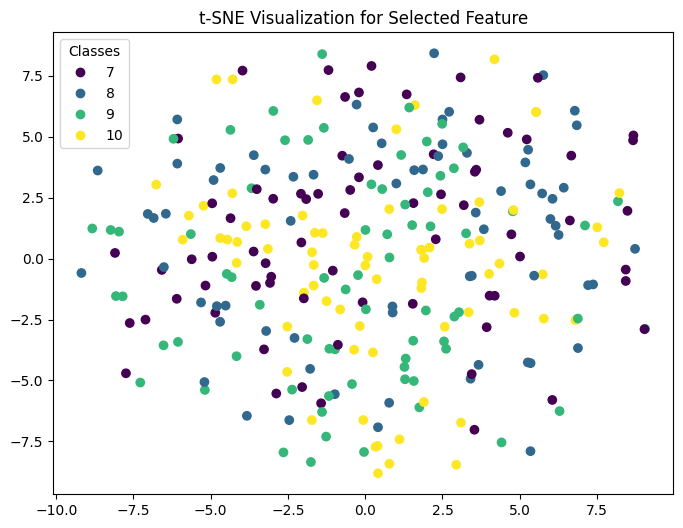

In [119]:
evaluate_tsne(features_selected, labels, 'Selected Feature')

In [120]:
evaluate_svm(features_selected, labels)

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           7       0.54      0.65      0.59        23
           8       0.56      0.50      0.53        20
           9       0.50      0.55      0.52        20
          10       0.83      0.65      0.73        23

    accuracy                           0.59        86
   macro avg       0.61      0.59      0.59        86
weighted avg       0.61      0.59      0.60        86

